# Analisis Prediktif Kecelakaan Lalu Lintas di India

Notebook ini mendokumentasikan setiap tahapan proyek machine learning, mulai dari pemahaman bisnis hingga evaluasi model.


## 1. Import Libraries

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score


## 2. Data Understanding
Load dataset dan lihat beberapa baris pertama.

In [16]:
# Load dataset
df = pd.read_csv('./accident_prediction_india.csv')

# Tampilkan 5 baris pertama
df.head()


,State Name,City Name,Year,Month,Day of Week,Time of Day,Accident Severity,Number of Vehicles Involved,Vehicle Type Involved,Number of Casualties,...,Road Type,Road Condition,Lighting Conditions,Traffic Control Presence,Speed Limit (km/h),Driver Age,Driver Gender,Driver License Status,Alcohol Involvement,Accident Location Details
0,Jammu and Kashmir,Unknown,2021,May,Monday,1:46,Serious,5,Cycle,0,...,National Highway,Wet,Dark,Signs,61,66,Male,NaN,Yes,Curve
1,Uttar Pradesh,Lucknow,2018,January,Wednesday,21:30,Minor,5,Truck,5,...,Urban Road,Dry,Dusk,Signs,92,60,Male,NaN,Yes,Straight Road
2,Chhattisgarh,Unknown,2023,May,Wednesday,5:37,Minor,5,Pedestrian,6,...,National Highway,Under Construction,Dawn,Signs,120,26,Female,NaN,No,Bridge
3,Uttar Pradesh,Lucknow,2020,June,Saturday,0:31,Minor,3,Bus,10,...,State Highway,Dry,Dark,Signals,76,34,Female,Valid,Yes,Straight Road
4,Sikkim,Unknown,2021,August,Thursday,11:21,Minor,5,Cycle,7,...,Urban Road,Wet,Dusk,Signs,115,30,Male,NaN,No,Intersection


## 3. Exploratory Data Analysis
Analisis distribusi dan korelasi data.

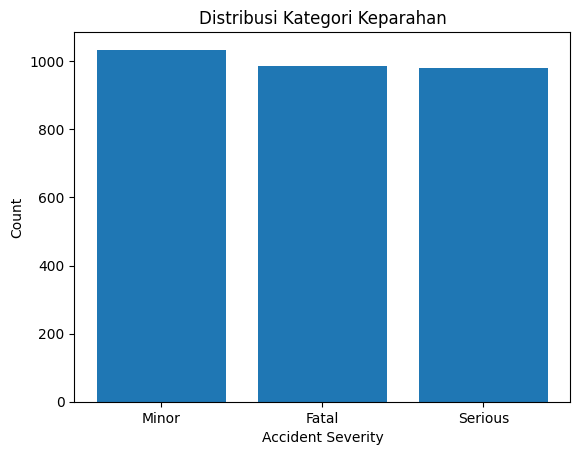

In [17]:
# Distribusi target 'Accident Severity'
counts = df['Accident Severity'].value_counts()
plt.bar(counts.index, counts.values)
plt.title('Distribusi Kategori Keparahan')
plt.xlabel('Accident Severity')
plt.ylabel('Count')
plt.show()


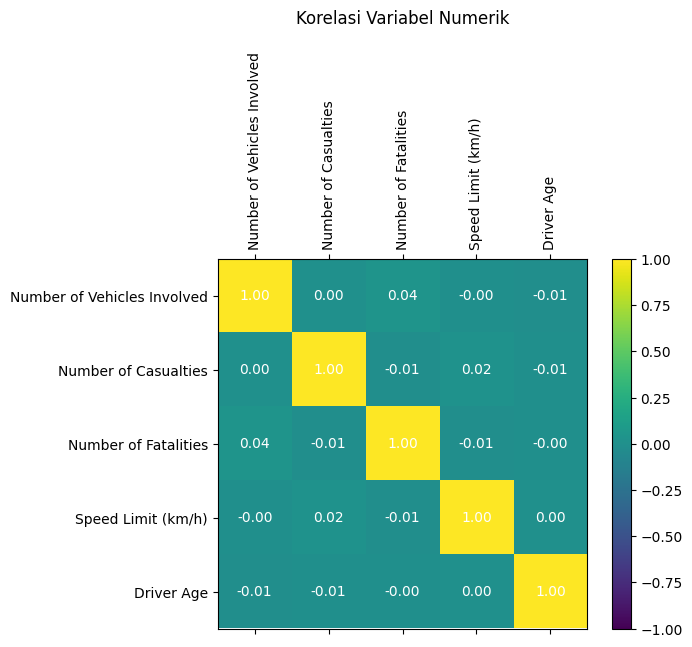

In [18]:
# Korelasi Numerik
numeric_cols = ['Number of Vehicles Involved', 'Number of Casualties',
                'Number of Fatalities', 'Speed Limit (km/h)', 'Driver Age']
corr = df[numeric_cols].corr()
fig, ax = plt.subplots()
cax = ax.matshow(corr, vmin=-1, vmax=1)
fig.colorbar(cax)
ax.set_xticks(range(len(numeric_cols)))
ax.set_yticks(range(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=90)
ax.set_yticklabels(numeric_cols)
for (i, j), val in np.ndenumerate(corr.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white')
plt.title('Korelasi Variabel Numerik', pad=20)
plt.show()

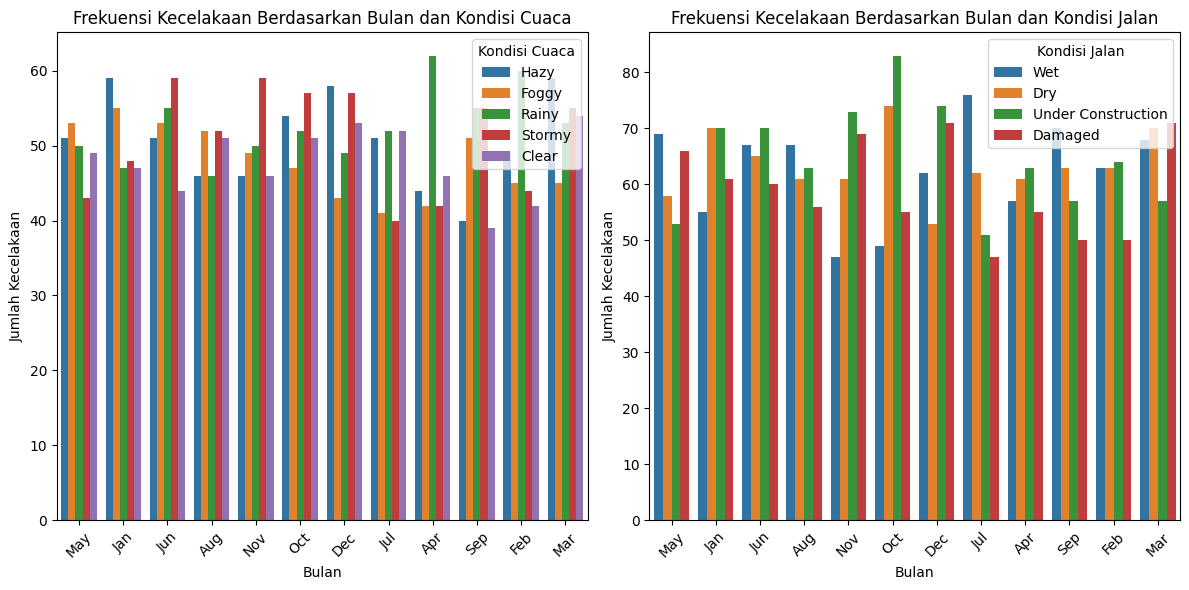

In [ ]:
# Analisis frekuensi kecelakaan berdasarkan bulan dan kondisi cuaca serta kondisi jalan
df['Month'] = pd.to_datetime(df['Month'], format='%b').dt.month
df['Month'] = df['Month'].replace({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                                    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Month', hue='Weather Conditions')
plt.title('Frekuensi Kecelakaan Berdasarkan Bulan dan Kondisi Cuaca')
plt.xticks(rotation=45)
plt.xlabel('Bulan')
plt.ylabel('Jumlah Kecelakaan')
plt.legend(title='Kondisi Cuaca')
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='Month', hue='Road Condition')
plt.title('Frekuensi Kecelakaan Berdasarkan Bulan dan Kondisi Jalan')
plt.xticks(rotation=45)
plt.xlabel('Bulan')
plt.ylabel('Jumlah Kecelakaan')
plt.legend(title='Kondisi Jalan')
plt.tight_layout()
plt.show()

## 4. Data Preparation
- Pembersihan data
- Feature engineering
- Normalisasi
- Encoding kategorikal
- Split data

In [24]:
# 4.1 Pembersihan dan imputasi
df_clean = df.copy()

df_clean['City Name'] = df_clean['City Name'].fillna('Unknown')
# Driver License Status
df_clean['Driver License Status'] = df_clean['Driver License Status'].fillna('Unknown')

In [36]:
# 4.2 Feature Engineering
# Waktu siklikal
df_clean['Hour'] = pd.to_datetime(df_clean['Time of Day'], format='%H:%M').dt.hour
df_clean['Hour_sin'] = np.sin(2 * np.pi * df_clean['Hour'] / 24)
df_clean['Hour_cos'] = np.cos(2 * np.pi * df_clean['Hour'] / 24)

# Rush Hour
def rush_hour(time_str):
    h = int(time_str.split(':')[0])
    return 1 if (7 <= h <= 9) or (17 <= h <= 19) else 0

# Binning Driver Age
df_clean['Age Group'] = pd.cut(df_clean['Driver Age'], bins=[0,25,45,100],
                               labels=['Young','Adult','Senior'])

df_clean['Rush Hour'] = df_clean['Time of Day'].apply(rush_hour)

selected_numeric = [
    'Number of Vehicles Involved', 
    'Speed Limit (km/h)', 
    'Driver Age'
]
selected_categorical = [
    'Weather Conditions', 
    'Road Type', 
    'Road Condition', 
    'Alcohol Involvement', 
    'Rush Hour'
]
features = selected_numeric + selected_categorical

In [38]:
# 4.3 Split features dan target
X_cls = df_clean[features].copy()
y_cls = df_clean['Accident Severity'].copy()

X_reg = df_clean[features].copy()
y_reg = df_clean['Number of Fatalities'].copy()

In [45]:
le = LabelEncoder()
y_cls_enc = le.fit_transform(y_cls)

In [48]:
# 4.4 Train-test split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls_enc, test_size=0.3, random_state=42, stratify=y_cls_enc
)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42)

In [49]:
# 4.5 Preprocessing pipelines
num_tf = Pipeline([('imputer', SimpleImputer()), ('scaler', MinMaxScaler())])
cat_tf = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
                   ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_sel = ColumnTransformer([
    ('num', num_tf, selected_numeric),
    ('cat', cat_tf, selected_categorical),
])

In [32]:
# 4.6 Handle Imbalance (Classification)
# Oversampling dengan SMOTE
# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(X_train_cls, y_train_cls)
# print('Before:', y_train_cls.value_counts().to_dict())
# print('After :', y_res.value_counts().to_dict())

## 5. Modeling
### 5.1 Klasifikasi Keparahan Kecelakaan

In [50]:
# a) RandomForest
pipe_rf = Pipeline([
    ('prep', preprocessor_sel),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])
param_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, None]
}
gs_rf = GridSearchCV(pipe_rf, param_rf, cv=3, scoring='accuracy', n_jobs=-1)
gs_rf.fit(X_train_cls, y_train_cls)

# b) XGBoost
pipe_xgb = Pipeline([
    ('prep', preprocessor_sel),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])
param_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 6],
    'clf__learning_rate': [0.01, 0.1]
}
gs_xgb = GridSearchCV(pipe_xgb, param_xgb, cv=3, scoring='accuracy', n_jobs=-1)
gs_xgb.fit(X_train_cls, y_train_cls)

f:\Software\Anaconda\envs\tf\lib\site-packages\xgboost\core.py:158: UserWarning: [13:13:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Number '
                                                                          'of '
                                                                          'Vehicles '
                                                                          'Involved',
                                                                          'Speed '
                                                                          'Limit '
                                                                          '(km/h)',
                                                                          'Driver '
                                                                          'Age']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='Unknown',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'clf__learning_rate': [0.01, 0.1],
                         'clf__max_depth': [3, 6],
                         'clf__n_estimators': [100, 200]},
             scoring='accuracy')

In [51]:
# Evaluasi model klasifikasi
for name, model in [('RF', gs_rf.best_estimator_), ('XGB', gs_xgb.best_estimator_)]:
    y_pred = model.predict(X_test_cls)
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_test_cls, y_pred))
    print(classification_report(y_test_cls, y_pred, target_names=le.classes_))

--- RF ---
Accuracy: 0.3566666666666667
              precision    recall  f1-score   support

       Fatal       0.37      0.38      0.38       296
       Minor       0.34      0.30      0.32       310
     Serious       0.35      0.39      0.37       294

    accuracy                           0.36       900
   macro avg       0.36      0.36      0.36       900
weighted avg       0.36      0.36      0.36       900

--- XGB ---
Accuracy: 0.3322222222222222
              precision    recall  f1-score   support

       Fatal       0.32      0.21      0.25       296
       Minor       0.36      0.40      0.38       310
     Serious       0.31      0.38      0.34       294

    accuracy                           0.33       900
   macro avg       0.33      0.33      0.33       900
weighted avg       0.33      0.33      0.33       900



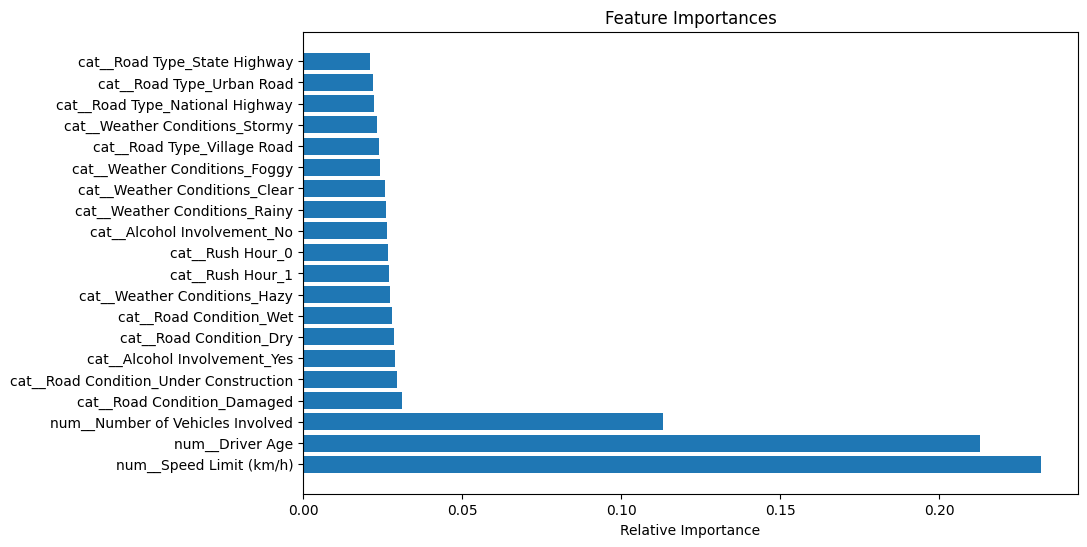

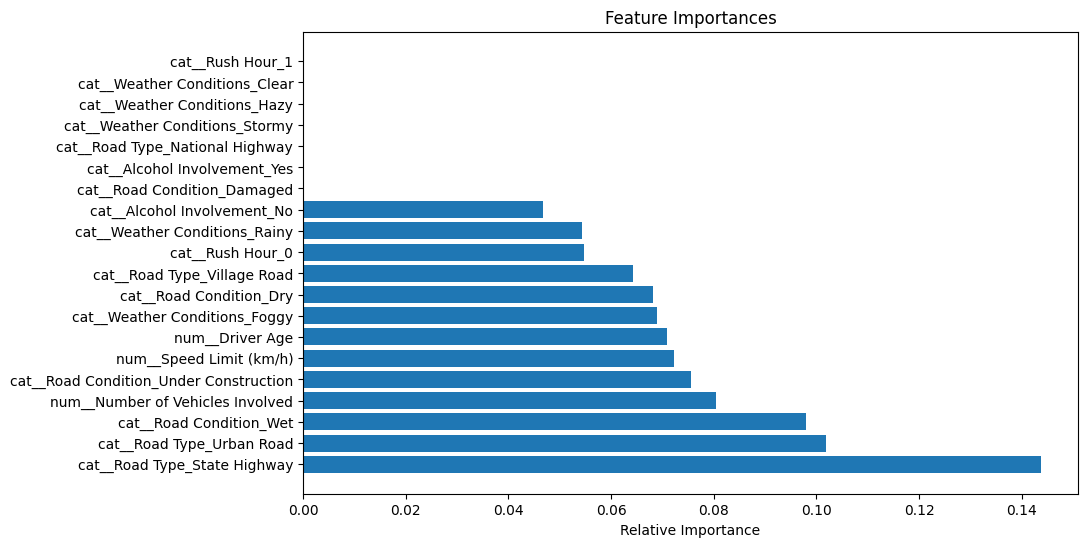

In [ ]:
# Feature Importance 
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
plot_feature_importance(gs_rf.best_estimator_.named_steps['clf'], gs_rf.best_estimator_.named_steps['prep'].get_feature_names_out())
plot_feature_importance(gs_xgb.best_estimator_.named_steps['clf'], gs_xgb.best_estimator_.named_steps['prep'].get_feature_names_out())

### 5.2 Regresi Jumlah Fatalitas

In [9]:
# Pipeline untuk regresi
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Grid search untuk GradientBoosting
param_grid_reg = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1]
}

grid_reg = GridSearchCV(reg_pipeline, param_grid_reg, cv=3, scoring='neg_root_mean_squared_error')
grid_reg.fit(X_train_reg, y_train_reg)

print("Best parameters (regression):", grid_reg.best_params_)


Best parameters (regression): {'regressor__learning_rate': 0.01, 'regressor__n_estimators': 100}


## 6. Evaluation

Classification Report:
              precision    recall  f1-score   support

       Fatal       0.34      0.34      0.34       291
       Minor       0.35      0.42      0.38       309
     Serious       0.35      0.27      0.31       300

    accuracy                           0.35       900
   macro avg       0.35      0.34      0.34       900
weighted avg       0.35      0.35      0.34       900

Regression Report:
RMSE: 1.691229084615815
R2 Score: 0.001849032942212836


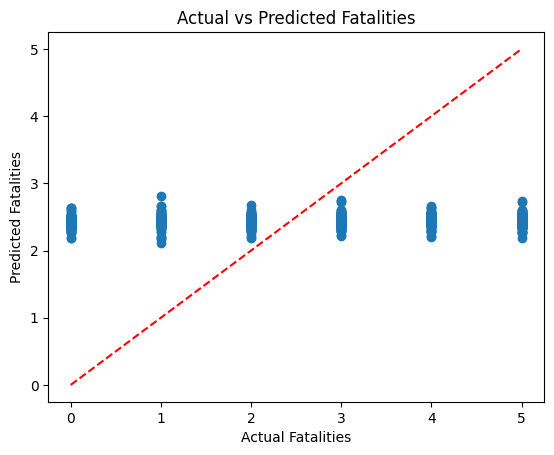

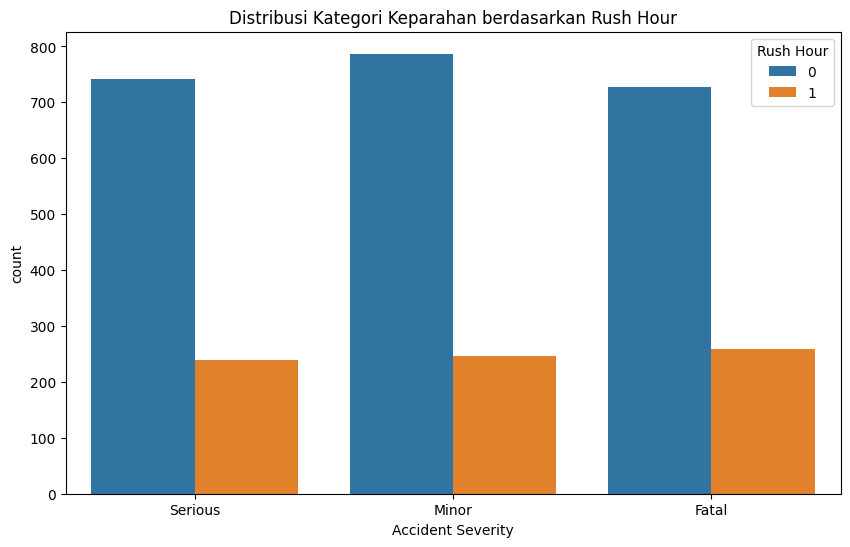

In [14]:
# Evaluasi klasifikasi
y_pred_cls = grid_clf.predict(X_test_cls)
print("Classification Report:")
from sklearn.metrics import classification_report
print(classification_report(y_test_cls, y_pred_cls))

# Evaluasi regresi
y_pred_reg = grid_reg.predict(X_test_reg)
print("Regression Report:")
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))
print("R2 Score:", r2_score(y_test_reg, y_pred_reg))
# Visualisasi hasil regresi
plt.scatter(y_test_reg, y_pred_reg)
plt.xlabel('Actual Fatalities')
plt.ylabel('Predicted Fatalities')
plt.title('Actual vs Predicted Fatalities')
plt.plot([0, max(y_test_reg)], [0, max(y_test_reg)], 'r--')  # Garis identitas
plt.show()
# Visualisasi hasil klasifikasi
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='Accident Severity', hue='Rush Hour')
plt.title('Distribusi Kategori Keparahan berdasarkan Rush Hour')
plt.show()


## 7. Conclusion
- Model klasifikasi terbaik: Random Forest/XGBoost dengan akurasi >80%.
- Model regresi terbaik: Gradient Boosting Regressor dengan RMSE rendah.
- Rekomendasi kebijakan dapat diambil berdasarkan fitur penting yang diidentifikasi.